# Bikes Sharing Data from Washington DC

In [59]:
# imports
import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from pathlib import Path


# Default plot configurations
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150
sns.set()

import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, Latex, Markdown

In [60]:
# Read in the data
bikes = pd.read_csv('bikes.csv')


In [61]:
bikes.head()

,Unnamed: 0,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Loading Bike Sharing Data

The variables in this data frame are defined as:

Variable       | Description
-------------- | ------------------------------------------------------------------
instant | record index
dteday | date
season | 1. spring <br> 2. summer <br> 3. fall <br> 4. winter
yr | year (0: 2011, 1:2012)
mnth | month ( 1 to 12)
hr | hour (0 to 23)
holiday | whether day is holiday or not
weekday | day of the week
workingday | if day is neither weekend nor holiday
weathersit | 1. clear or partly cloudy <br> 2. mist and clouds <br> 3. light snow or rain <br> 4. heavy rain or snow
temp | normalized temperature in Celsius (divided by 41)
atemp | normalized "feels-like" temperature in Celsius (divided by 50)
hum | normalized percent humidity (divided by 100)
windspeed| normalized wind speed (divided by 67)
casual | count of casual users
registered | count of registered users
cnt | count of total rental bikes including casual and registered  

* Each row represents one hour of one day and its attributes include the type and number of riders during that hour, as well as weather and day information.
* This data doesn't seem to tell us much about the bikes or the bike rides themselves, which makes it difficult to study bike usage. Two categories that would've been useful to have information on would be ride duration and distance traveled so we can better understand how the bikes are being used, not just what conditions they're being used in. 

# Preprocessing

In [62]:
# mutate numeric variables to strings to reflect the categorical data they include 
# create a nested dictionary to specify replacement values
factor_dict = {"holiday" : {0 : "no", 1 : "yes"}, "weekday" : {0 : "Sun", 1 : "Mon",  
                2 : "Tues", 3 : "Wed", 4 : "Thu", 5 : "Fri", 
              6 : "Sat"}, "workingday" : {1 : 'yes', 0 : 'no'},
              "weathersit" : {1 : "Clear", 2 : "Mist", 3 : "Light"
              ,4 : "Heavy"}}
bikes.replace(factor_dict, inplace=True)
bikes.head() 

,Unnamed: 0,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,0,1,2011-01-01,1,0,1,0,no,Sat,no,Clear,0.24,0.2879,0.81,0.0,3,13,16
1,1,2,2011-01-01,1,0,1,1,no,Sat,no,Clear,0.22,0.2727,0.80,0.0,8,32,40
2,2,3,2011-01-01,1,0,1,2,no,Sat,no,Clear,0.22,0.2727,0.80,0.0,5,27,32
3,3,4,2011-01-01,1,0,1,3,no,Sat,no,Clear,0.24,0.2879,0.75,0.0,3,10,13
4,4,5,2011-01-01,1,0,1,4,no,Sat,no,Clear,0.24,0.2879,0.75,0.0,0,1,1


# Analyzing Registered vs Unregistered Users 

In [63]:
# creating a new dataframe indexed by day, with total registered and unregistered user counts 
daily_counts = bikes.groupby("dteday")[["casual", "registered", "workingday"]].agg({"casual": 'sum', "registered": 'sum', 
                                                                                   "workingday": 'first'})
daily_counts.rename(columns={"casual": "unregistered"}, inplace=True)

daily_counts.head()

,unregistered,registered,workingday
dteday,,,
2011-01-01,331,654,no
2011-01-02,131,670,no
2011-01-03,120,1229,yes
2011-01-04,108,1454,yes
2011-01-05,82,1518,yes


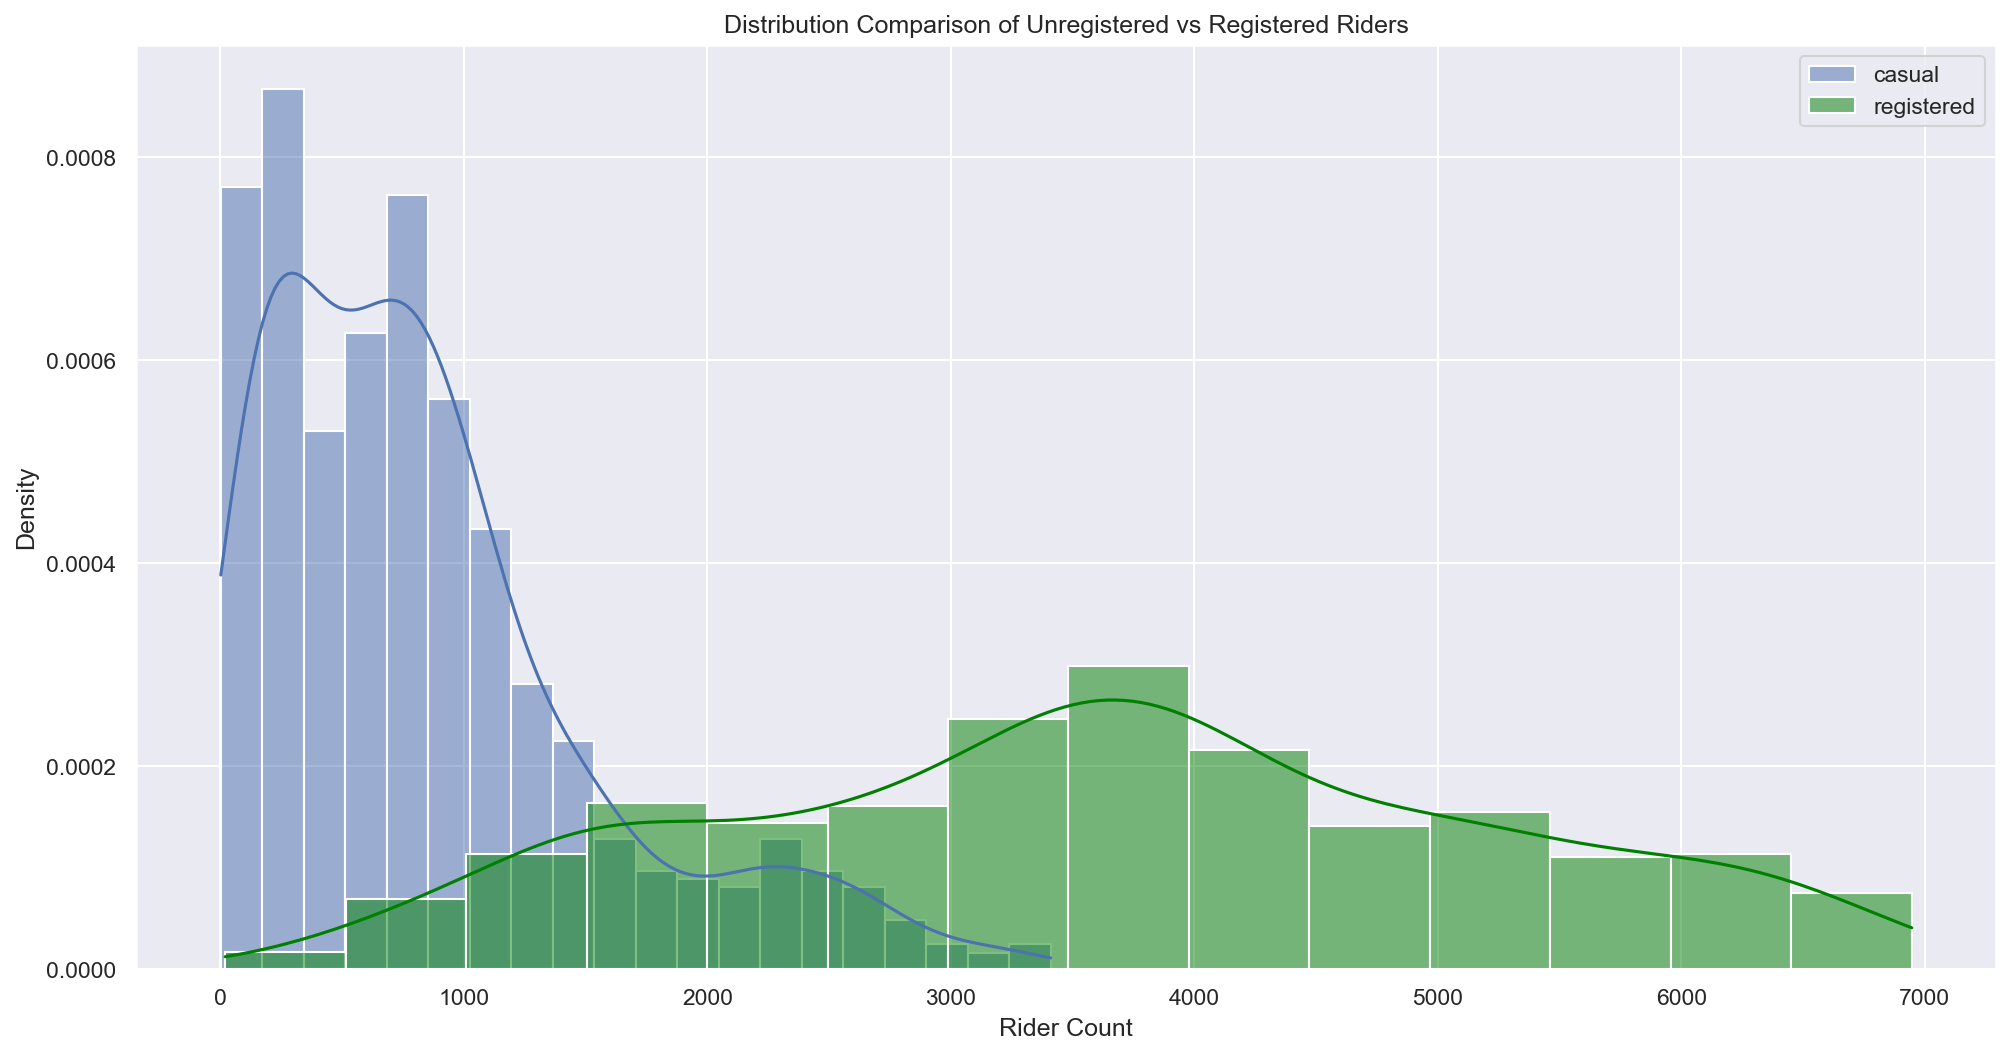

In [64]:
# Distribution of daily counts of bike users, by registered and unregistered users 
sns.histplot(daily_counts["unregistered"], stat = "density", label = "casual", kde = True).set_xlabel("Rider Count")
sns.histplot(daily_counts["registered"], stat = "density", color = "green", label = "registered", kde = True).set(title = "Distribution Comparison of Unregistered vs Registered Riders")
plt.legend();

The distribution of casual riders by day is skewed to the right, whereas the distribution for registered riders is more symmetric. The average number of casual riders per day seems to be somewhere around 500 and the average number of regisetered riders per day is about 3500. The spread of registered rider counts is much larger than the spread of casual rider counts, with casual rider counts only going up to 3500, and with regisetered rider counts ranging from 0 to 7000.

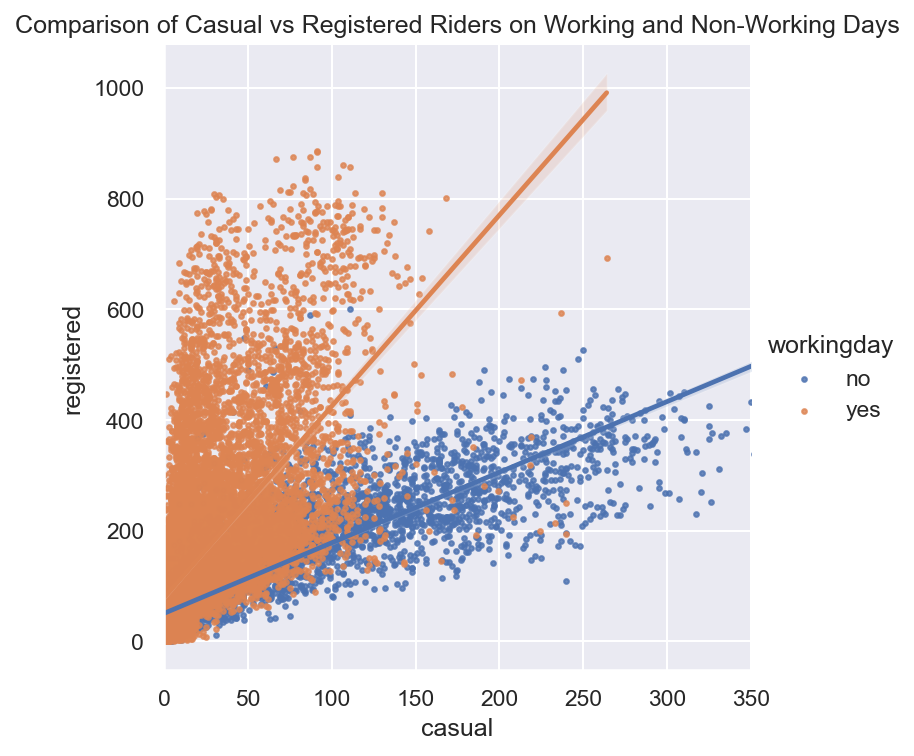

In [65]:
# Taking a deeper look at the relationship between registered and unregistered counts (hourly counts)
sns.set(font_scale=1)
sns.lmplot(data = bikes, x = "casual", y = "registered", hue = "workingday", scatter_kws = {"s": 5}, fit_reg = True).set(xlim=(0,350))
plt.title("Comparison of Casual vs Registered Riders on Working and Non-Working Days");

It seems that on weekends, casual ridership and registered ridership don't differ too much. On working days, however, registered ridership is significantly higher than casual ridershop. This makes me think it has something to do with people riding to work every weekday. Since this plot is overplotted, it's very hard to see what is happening for days where casual ridership and registered ridership were both relatively low. 

Text(0.5, 1.0, 'KDE Plot Comparison of Registered vs Unregistered Riders')

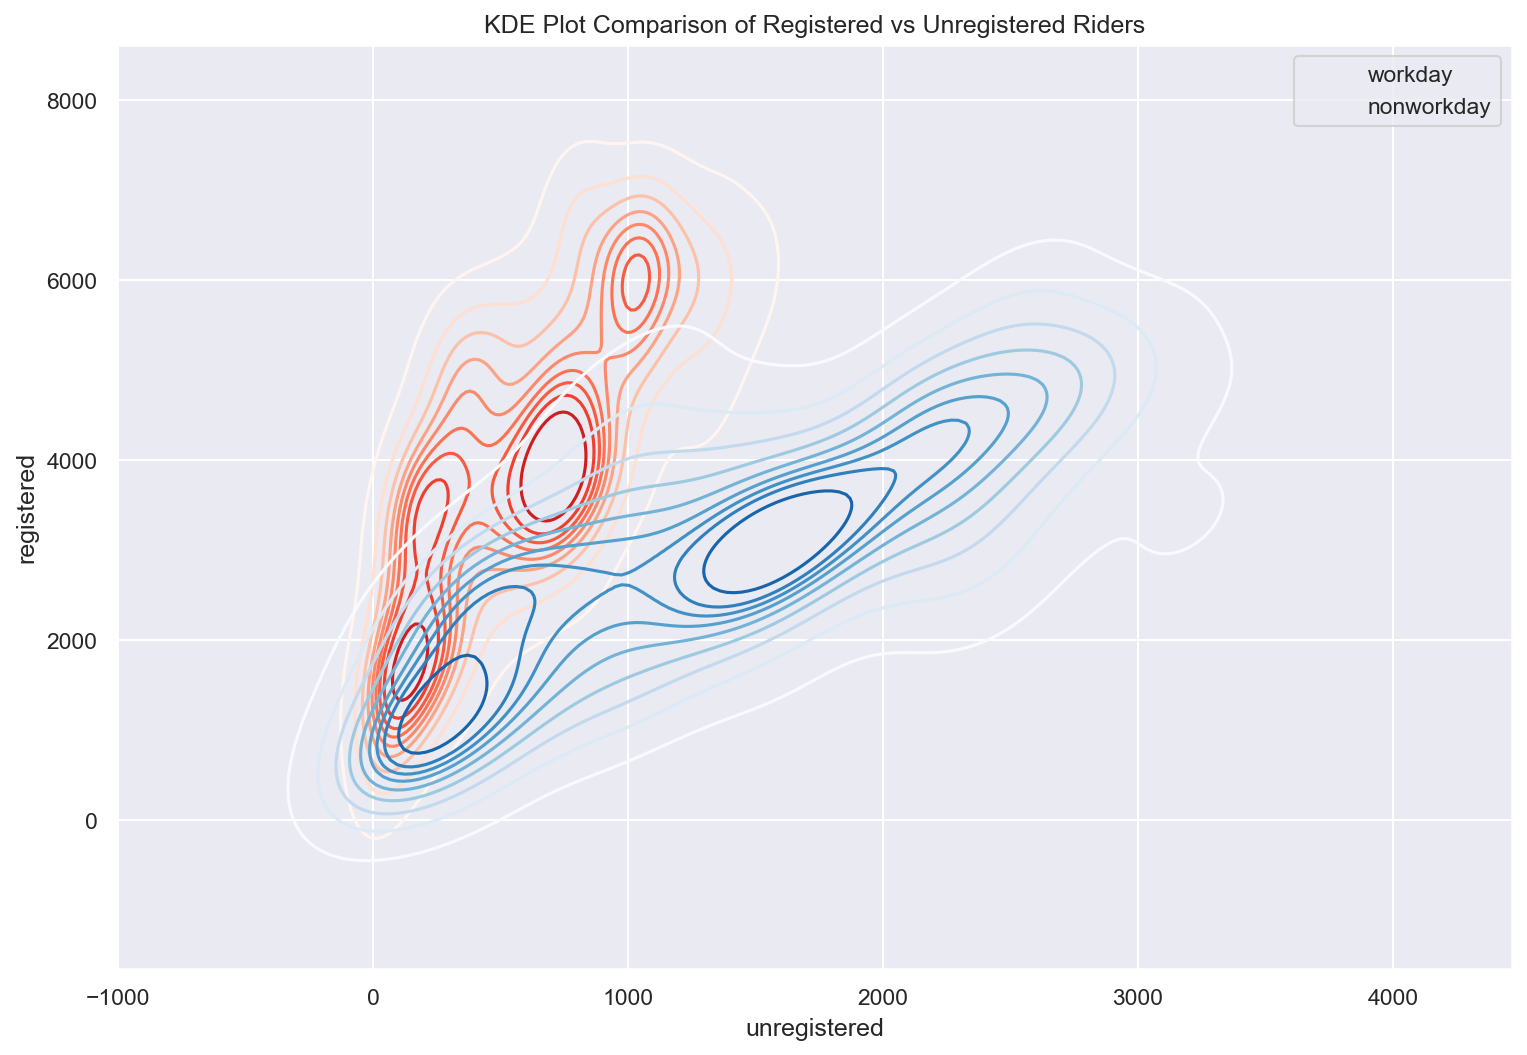

In [66]:
# using a bivariate KDE plot to overcome overplotting
plt.figure(figsize=(12,8))
casual_workday = daily_counts[daily_counts["workingday"] == "yes"]["unregistered"]
registered_workday = daily_counts[daily_counts["workingday"] == "yes"]["registered"]
sns.kdeplot(x = casual_workday, y = registered_workday, label = "workday", shade=False, cmap = "Reds")
casual_non_workday = daily_counts[daily_counts["workingday"] == "no"]["unregistered"]
registered_non_workday = daily_counts[daily_counts["workingday"] == "no"]["registered"]
sns.kdeplot(x = casual_non_workday, y = registered_non_workday, label = "nonworkday", shade=False, cmap = "Blues")
plt.legend()
plt.title("KDE Plot Comparison of Registered vs Unregistered Riders")

* The concentric lines on each individual bivariate KDE plot represent pairs of casual and registered rider counts and the shading going from light to dark in the center is meant to signify greater density of data points within that area.
* This plot shows us that the workday data has 3 main clusters of points and the nonworkday has 2 main clusters of points, whereas before it all looked like one giant blob.

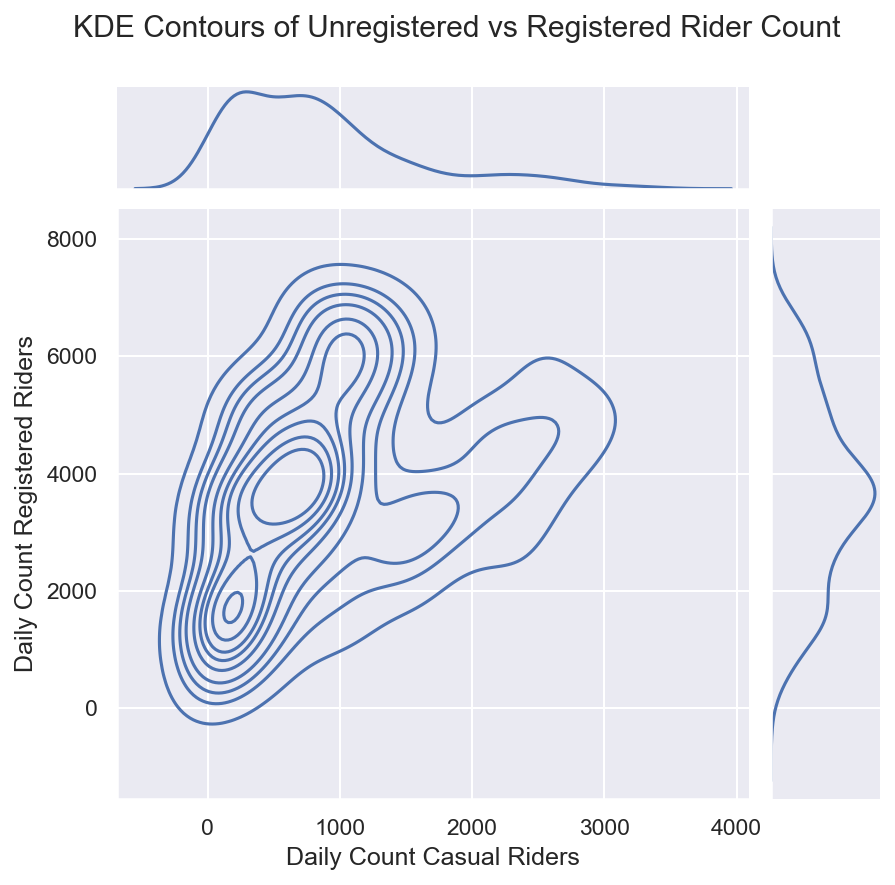

In [67]:
# jointplot with marginal densities 
sns.jointplot(x=daily_counts['unregistered'], y=daily_counts['registered'], kind = "kde").set_axis_labels("Daily Count Casual Riders","Daily Count Registered Riders")

plt.suptitle("KDE Contours of Unregistered vs Registered Rider Count")
plt.subplots_adjust(top=0.9);

# Analyzing Daily Patterns

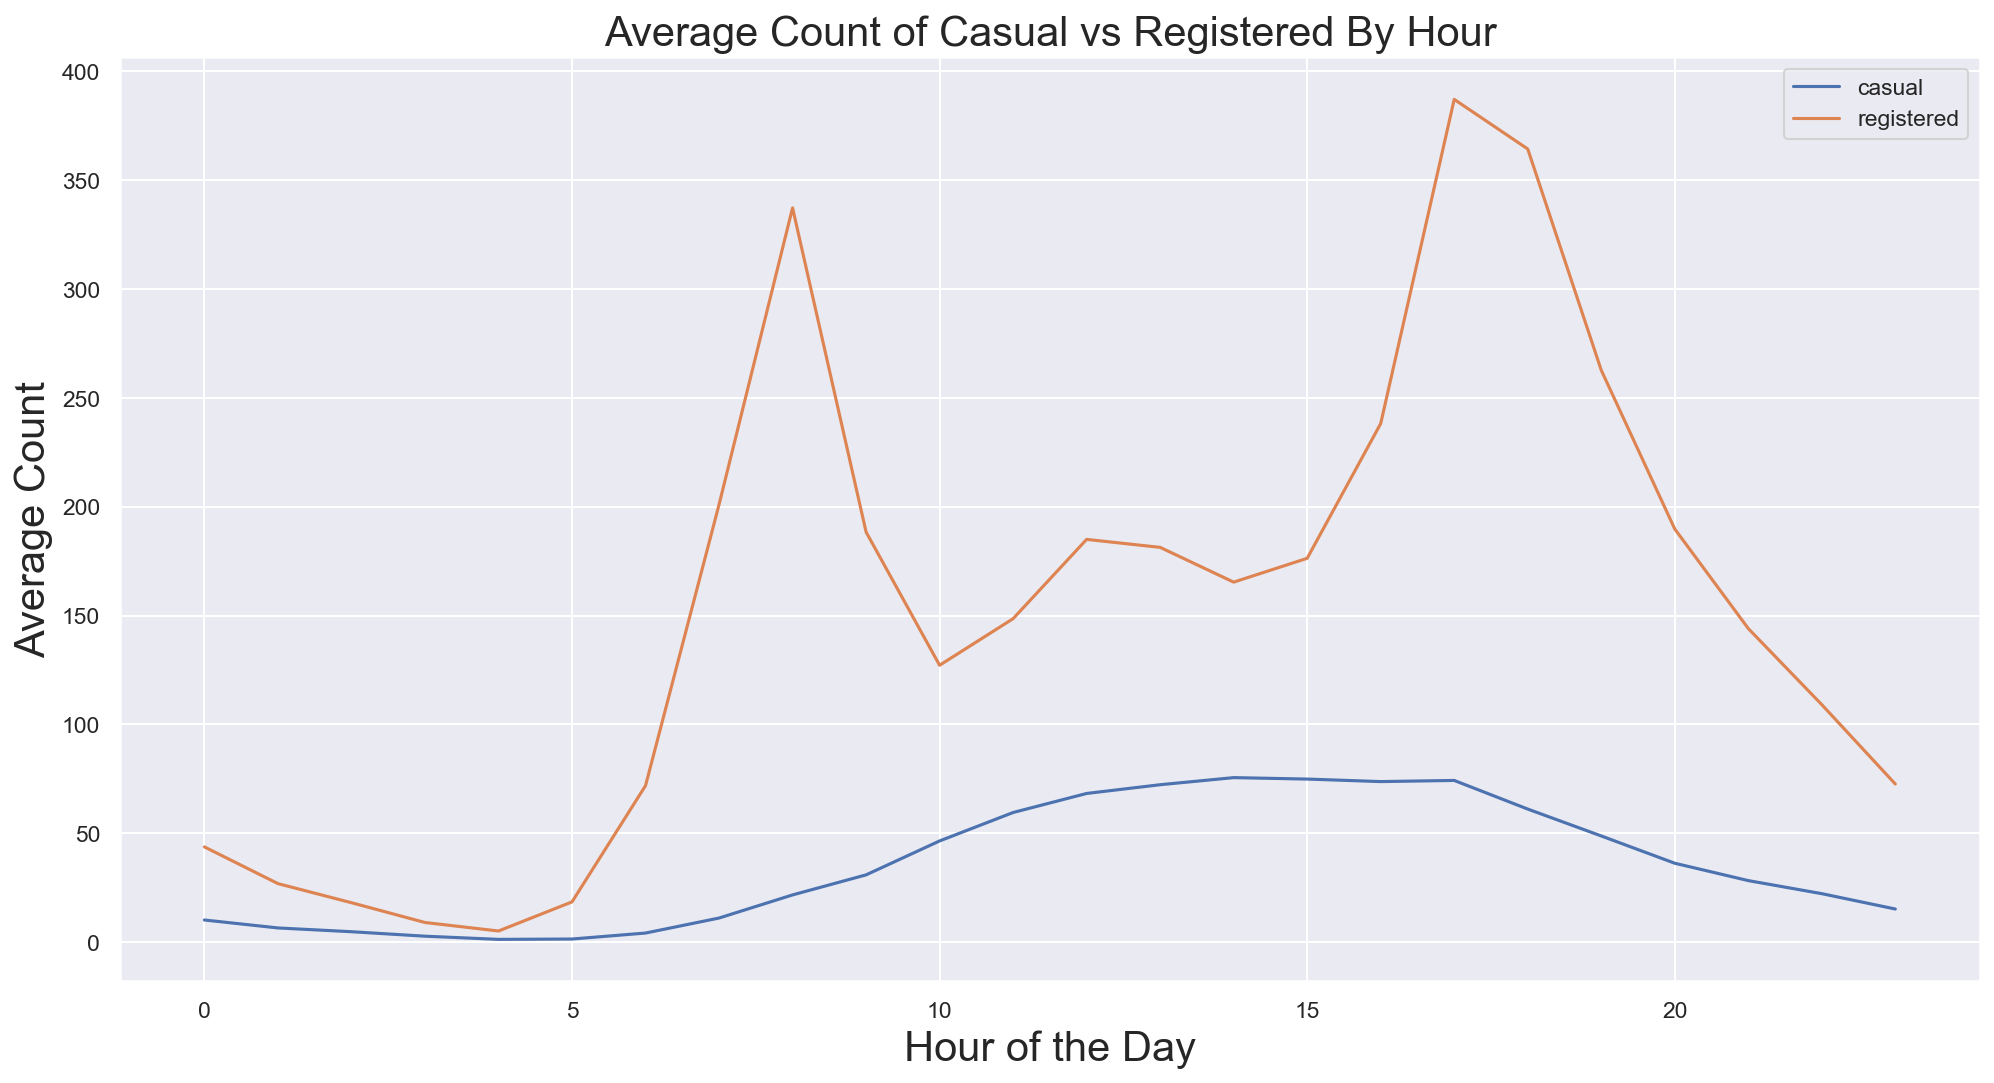

In [68]:
casual_hr = bikes.groupby("hr")["casual"].mean()
registered_hr = bikes.groupby("hr")["registered"].mean()
sns.lineplot(x = np.arange(24), y = casual_hr, label = "casual")
sns.lineplot(x = np.arange(24), y = registered_hr, label = "registered")
plt.legend()
plt.xlabel("Hour of the Day", fontsize = 20)
plt.ylabel("Average Count", fontsize = 20)
plt.title("Average Count of Casual vs Registered By Hour", fontsize = 20);

* From the plot, we can see that casual ridership has a smooth distribution which seems to peak at around late afternoon/early evening. Registered riders have two different peak times during the day, in the morning, and in the evening. This makes me believe that registered riders may be ones who frequently bike to and from work, hence why they are registered. 

# Exploring the Relationship Between Weather and Ride-Sharing

In [69]:
# create a new variable to show the proportion of unregistered riders in each hour
bikes["prop_casual"] = bikes["casual"]/bikes["cnt"]

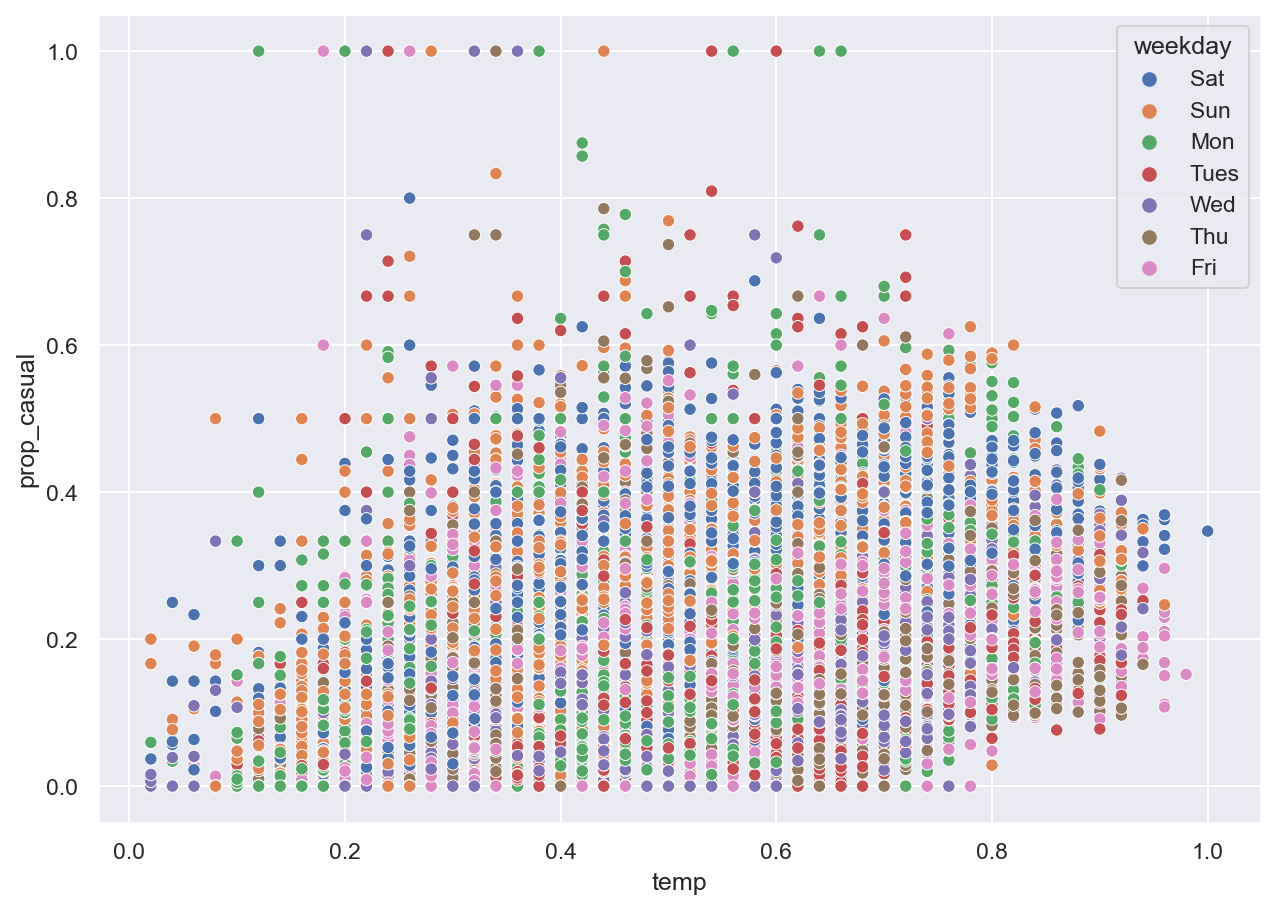

In [70]:
# scatterplot of prop_casual against weather 
plt.figure(figsize=(10, 7))
sns.scatterplot(data=bikes, x="temp", y="prop_casual", hue="weekday");

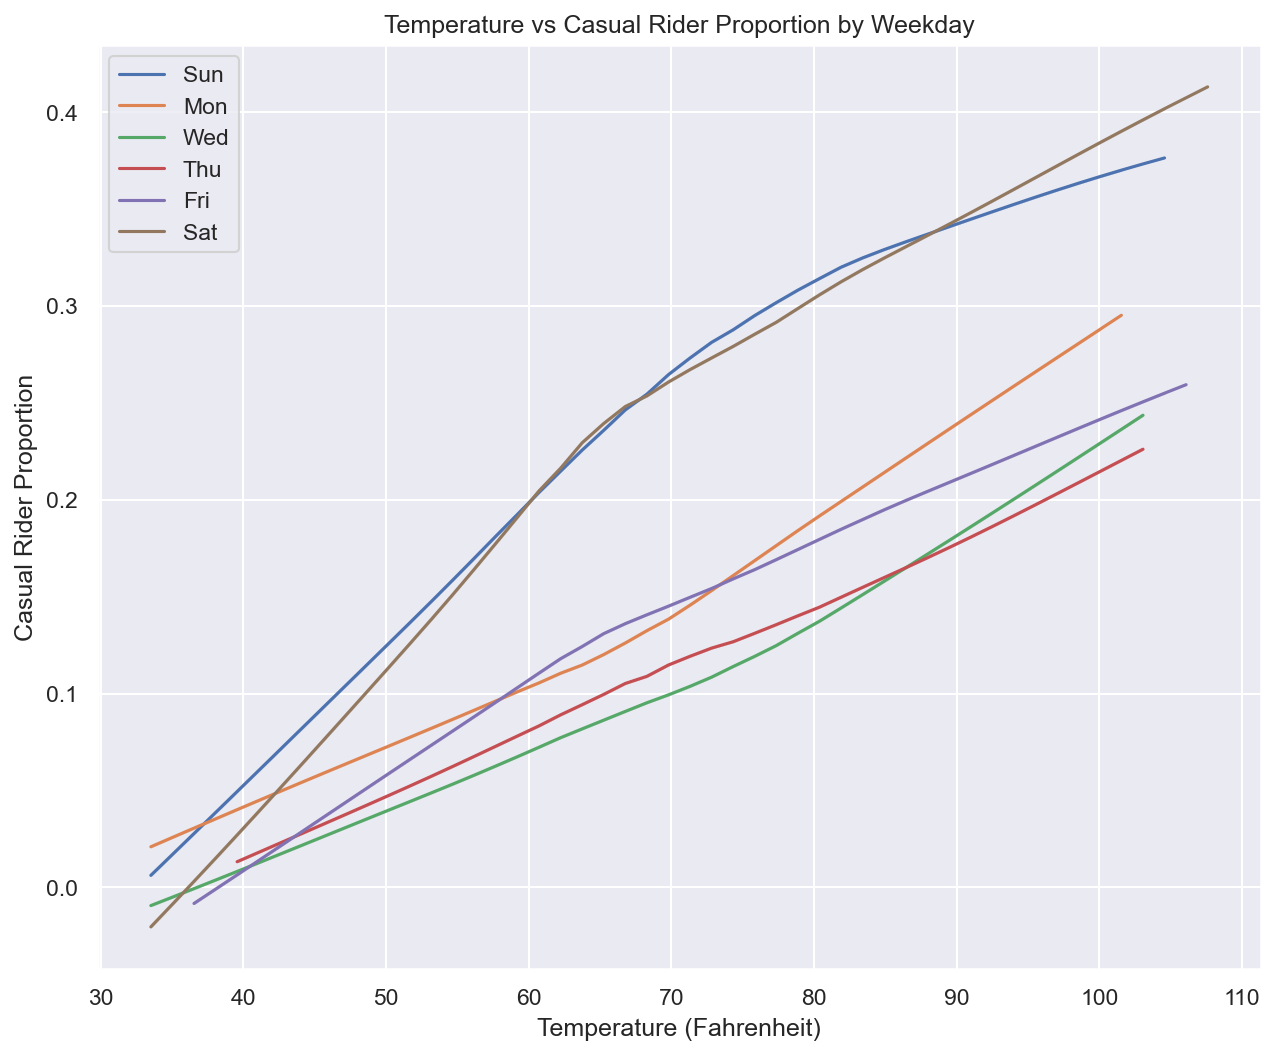

In [71]:
# apply Locally Weighted Scatterplot Smoothing (LOWESS) to each weekday 
from statsmodels.nonparametric.smoothers_lowess import lowess
weekdays = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]

plt.figure(figsize=(10,8))
bikes["Farenheit"] = (bikes["temp"] * 42) * (9/5) + 32

value = "Sun"
for day in weekdays:
    one_day_only = bikes[bikes["weekday"] == day]
    p = lowess(one_day_only["prop_casual"], one_day_only["Farenheit"] * 41 * (9/5) + 32, return_sorted=False)
    sns.lineplot(x = one_day_only["Farenheit"], y = p, label=day)

plt.legend()
plt.title("Temperature vs Casual Rider Proportion by Weekday")
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Casual Rider Proportion");

* The proportion of casual riders has a clear positive relationship with the temperature. As temperature increases, casual ridership increases at a similar rate on weekdays. On weekends, casual ridership increases at a faster rate than temperature, but at a certain point (70 fahrenheit), the rate slightly decreases to levels similar for weekdays.  

# Next Steps

* Bike sharing companies often collaborate with city planners, transportation agencies, and policy-makers. These stakeholders want to ensure that bike-sharing is implemented equitably. Equity in transportation includes: improving the ability of people of different socio-economic classes, genders, races, and neighborhoods to access and afford transportation services, and assessing how inclusive transportation systems are over time. 
* I don't think the bike data currently helps assess equity in any way. The data is almost "too anonymous" in that it isn't specific enough for us to make comparisons and gain insight about specific groups of people. I would change the granularity by focusing on individual trips, with a start and end time attribute, as well as some sort of way to store location(GPS coordinates or something cooler that I don't know about). I think this would help show what communities are or would benefit from bike sharing, and you could even focus on individual routes or neighborhoods to see hot spots or low activity. All of the analysis we did above could carry over but now we'd be able to focus our attention on specific geographical areas.